In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBRanker

In [17]:
df = pd.read_csv("Reviews.csv")
col = 'Summary'

mask_empty = (
    df[col].isna() |
    df[col].astype(str).str.strip().eq('') |
    df[col].astype(str).str.lower().isin(['nan', 'none', 'null'])
)
df = df[~mask_empty].copy()
df = df.reset_index(drop=True)
print(df)

            Id   ProductId          UserId                      ProfileName  \
0            1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1            2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2            3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3            4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4            5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...        ...         ...             ...                              ...   
568418  568450  B001EO7N10  A28KG5XORO54AY                 Lettie D. Carter   
568419  568451  B003S1WTCU  A3I8AFVPEE8KI5                        R. Sawyer   
568420  568452  B004I613EE  A121AA1GQV751Z                    pksd "pk_007"   
568421  568453  B004I613EE   A3IBEVCTXKNOH          Kathy A. Welch "katwel"   
568422  568454  B001LR2CU2  A3LGQPJCZVL9UC                         srfell17   

        HelpfulnessNumerator  HelpfulnessDenominato

In [18]:
print(df.columns)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [19]:
print(df['Score'])

0         5
1         1
2         4
3         2
4         5
         ..
568418    5
568419    2
568420    5
568421    5
568422    5
Name: Score, Length: 568423, dtype: int64


In [20]:
df.drop(columns=["Id", "ProfileName", "Time"], inplace=True)

In [21]:
tfidf = TfidfVectorizer(stop_words="english",max_features=200)
tfidf_overview = tfidf.fit_transform(df['Summary'])

overview_df = pd.DataFrame(tfidf_overview.toarray(), columns= tfidf.get_feature_names_out()).reindex(df.index,fill_value=0)


In [22]:
print(overview_df)

        absolutely  addictive  alternative  amazing  amazon  awesome  awful  \
0              0.0        0.0          0.0      0.0     0.0      0.0    0.0   
1              0.0        0.0          0.0      0.0     0.0      0.0    0.0   
2              0.0        0.0          0.0      0.0     0.0      0.0    0.0   
3              0.0        0.0          0.0      0.0     0.0      0.0    0.0   
4              0.0        0.0          0.0      0.0     0.0      0.0    0.0   
...            ...        ...          ...      ...     ...      ...    ...   
568418         0.0        0.0          0.0      0.0     0.0      0.0    0.0   
568419         0.0        0.0          0.0      0.0     0.0      0.0    0.0   
568420         0.0        0.0          0.0      0.0     0.0      0.0    0.0   
568421         0.0        0.0          0.0      0.0     0.0      0.0    0.0   
568422         0.0        0.0          0.0      0.0     0.0      0.0    0.0   

        baby  bad  bag  ...  water  way  weak  wond

In [23]:
y = df['Score'].astype(str)
group=[len(df)]
print(y)

0         5
1         1
2         4
3         2
4         5
         ..
568418    5
568419    2
568420    5
568421    5
568422    5
Name: Score, Length: 568423, dtype: object


In [24]:
user_score = ['5']
user_idx = df[y.isin(user_score)].index

X_ = overview_df.iloc[user_idx]
Y_ = y.iloc[user_idx]

print(X_.shape)
print(Y_.shape)

(363120, 200)
(363120,)


In [25]:
model = XGBRanker(
    objective="rank:pairwise",
    n_estimators=200,
    learning_rate=0.0001,
    max_depth=7,
    subsample=0.7,
    colsample_bytree=0.8,
    enable_categorical=True,
)

model.fit(overview_df, y, group=group)

,objective,'rank:pairwise'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [26]:
user_vec = overview_df.iloc[user_idx].mean(axis=0).values.reshape(1, -1)
print("User vector shape:", user_vec.shape)

similarity_score = cosine_similarity(overview_df, user_vec).flatten()
print("Similarity shape:", similarity_score.shape)

User vector shape: (1, 200)
Similarity shape: (568423,)


In [27]:
user_predict = model.predict(user_vec)

In [28]:
booster = model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

In [29]:
for feature,score in sorted(importance_dict.items(), key=lambda imp: imp[1], reverse=True):
    print(f"{feature.capitalize():20} {score}")

Flavor               12.029555320739746
Great                7.6787190437316895
Smooth               4.551055431365967
Breakfast            4.186650276184082
Wow                  3.6032323837280273
Packaging            3.0922398567199707
High                 1.5588767528533936
Old                  1.4751356840133667
Coffee               1.0037803649902344
Good                 0.30057746171951294
Dog                  0.2562732696533203
Taste                0.16034367680549622
Tastes               0.09419592469930649


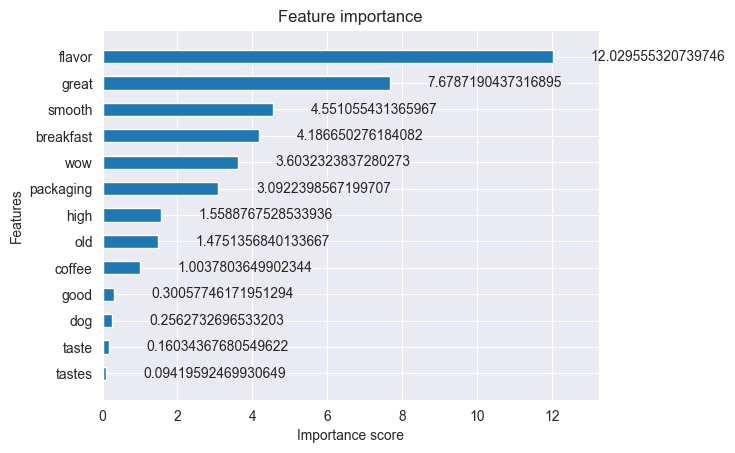

In [30]:
from matplotlib import pyplot as plt
from xgboost import plot_importance

plot_importance(model, importance_type="gain", max_num_features=15, height=0.5)
plt.show()